# Adversarial Patch Defence


## Imports & Globals

In [17]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
from torchvision import datasets, transforms, models

os.chdir('/home/jovyan/DL_Project02')
!pwd

/home/jovyan/DL_Project02


## Load Dataset and Calssification model

In [18]:

DATA_ROOT = "./data_gtsrb"
IMG_SIZE = 224
BATCH_SIZE = 8
NUM_WORKERS = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

train_set = datasets.GTSRB(
    DATA_ROOT, 
    split="train", 
    download=True, 
    transform=tfms
)

test_set  = datasets.GTSRB(
    DATA_ROOT, 
    split="test",  
    download=True, 
    transform=tfms
)

indices = random.sample(range(len(train_set)), 600)
small_train_set = Subset(train_set, indices)

indices = random.sample(range(len(test_set)), 600)
small_test_set = Subset(test_set, indices)

test_loader = DataLoader(
    test_set, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)


cuda


In [19]:

CKPT_PATH = "./ResNet_Models/resnet101_gtsrb_best.pt"
NUM_CLASSES = 43
weights = models.ResNet101_Weights.IMAGENET1K_V2
model = models.resnet101(weights=weights)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

ckpt = torch.load(CKPT_PATH, map_location=DEVICE)

# Robust: checkpoint might be {"model_state": ...} or directly a state_dict
state_dict = ckpt["model_state"] if isinstance(ckpt, dict) and "model_state" in ckpt else ckpt
model.load_state_dict(state_dict)

model.to(DEVICE).eval();

## Patch Segmentation Dataset

In [20]:
class PatchSegmentationDataset(Dataset):
    def __init__(self, base_dataset, patch, patch_size):
        self.base_dataset = base_dataset
        self.patch = patch.detach().cpu()   # ensure CPU tensor
        self.patch_size = patch_size

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx]
        img = img.clone()                   # safety

        _, H, W = img.shape
                
        mask = torch.zeros((1, H, W), dtype=torch.float32)

        # random patch position
        x = random.randint(0, W - self.patch_size)
        y = random.randint(0, H - self.patch_size)

        # apply patch
        img[:, y:y+self.patch_size, x:x+self.patch_size] = self.patch

        # ground-truth mask
        mask[:, y:y+self.patch_size, x:x+self.patch_size] = 1.0

        return img, mask


patch = torch.load(f"./Patches/Target_9_patch_SRT9351_MR9502.pt")
seg_dataset = PatchSegmentationDataset(small_train_set, patch, patch_size=40)
seg_loader = DataLoader(seg_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

seg_test_dataset = PatchSegmentationDataset(small_test_set, patch, patch_size=40)
seg_test_loader = DataLoader(seg_test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)


## Visualise train dataset

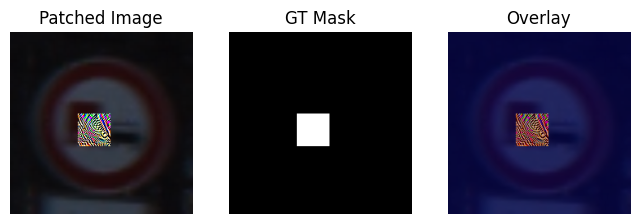

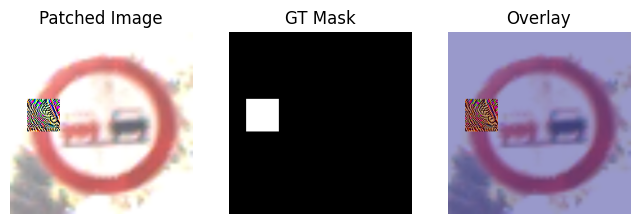

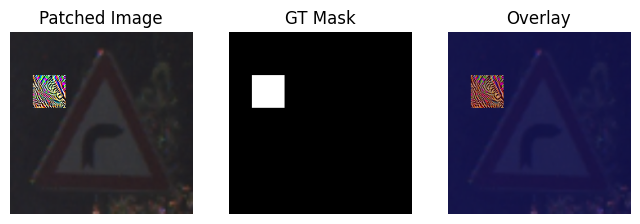

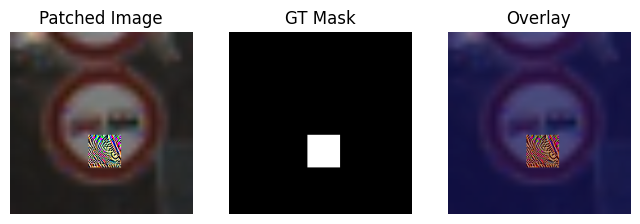

In [21]:

def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(3,1,1)
    std  = torch.tensor(std).view(3,1,1)
    return img * std + mean


# get one batch
images, masks = next(iter(seg_loader))
images = images[:4]
masks = masks[:4]

for i in range(4):
    img = denormalize(images[i], imagenet_mean, imagenet_std)
    img = img.permute(1,2,0).clamp(0,1)

    mask = masks[i][0]

    plt.figure(figsize=(8,3))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Patched Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(mask, cmap="gray")
    plt.title("GT Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(img)
    plt.imshow(mask, cmap="jet", alpha=0.4)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()


## Define and Train the Patch detector
A U-model is used to detect the patches using as a mask as ground truth  

In [27]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DoubleConv(3, 64)
        self.d2 = DoubleConv(64, 128)
        self.b = DoubleConv(128, 256)
        self.u1 = DoubleConv(256 + 128, 128)
        self.u2 = DoubleConv(128 + 64, 64)
        self.out = nn.Conv2d(64, 1, 1)

        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        c1 = self.d1(x)
        c2 = self.d2(self.pool(c1))
        b = self.b(self.pool(c2))
        u1 = self.u1(torch.cat([torch.nn.functional.interpolate(b, scale_factor=2), c2], dim=1))
        u2 = self.u2(torch.cat([torch.nn.functional.interpolate(u1, scale_factor=2), c1], dim=1))
        return torch.sigmoid(self.out(u2))


In [28]:
EPOCHS = 5

seg_model = UNet().cuda()
opt = torch.optim.Adam(seg_model.parameters(), 1e-4)
loss_fn = nn.BCELoss()

for epoch in range(EPOCHS):
    total_loss = 0.0

    for images, masks in seg_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        preds = seg_model(images)
        loss = loss_fn(preds, masks)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: avg loss = {total_loss / len(seg_loader):.4f}")


Epoch 1: avg loss = 0.2220
Epoch 2: avg loss = 0.0058
Epoch 3: avg loss = 0.0017
Epoch 4: avg loss = 0.0010
Epoch 5: avg loss = 0.0007


## Visualise the segmentation results

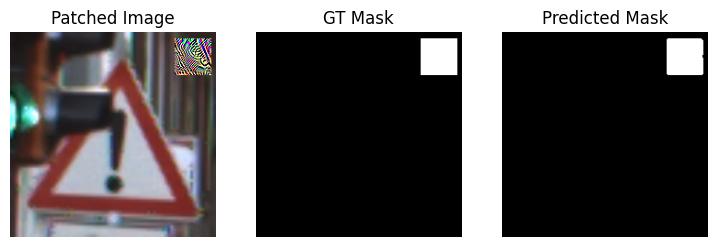

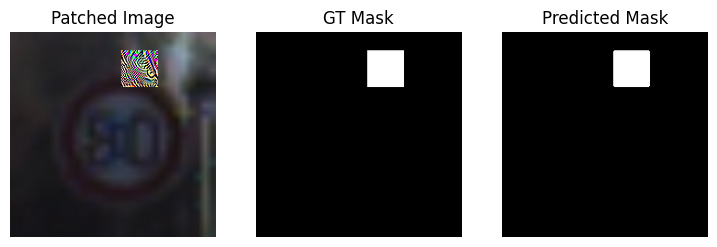

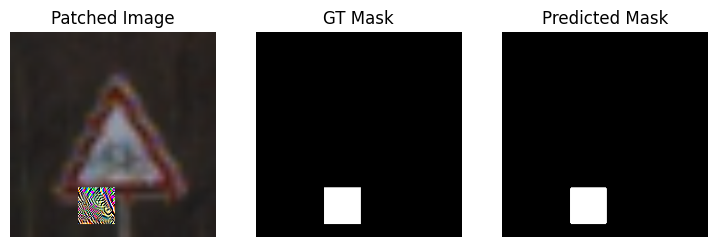

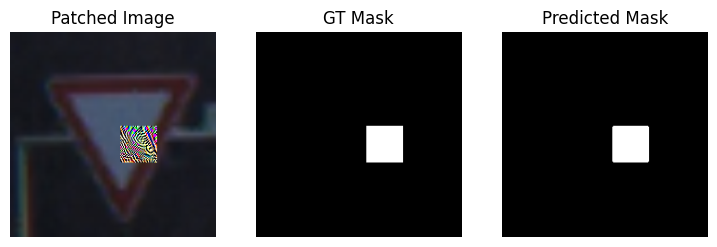

In [29]:
seg_model.eval()
torch.save(seg_model.state_dict(), "./Segmentation_Models/seg_Umodel.pth")

with torch.no_grad():
    images, masks = next(iter(seg_loader))
    images = images[:4].to(DEVICE)
    masks = masks[:4]

    preds = seg_model(images).cpu()

for i in range(4):
    img = denormalize(images[i].cpu(), imagenet_mean, imagenet_std)
    img = img.permute(1,2,0).clamp(0,1)

    gt_mask = masks[i][0]
    pred_mask = (preds[i][0] > 0.5).float()

    plt.figure(figsize=(9,3))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Patched Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(gt_mask, cmap="gray")
    plt.title("GT Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


In [30]:
def remove_patch(images, masks):
    """
    images: [B,3,H,W]
    masks:  [B,1,H,W]
    """
    cleaned = images.clone()

    masks = masks.expand(-1, 3, -1, -1)

    # image-wise mean color
    mean = images.mean(dim=[2,3], keepdim=True)

    cleaned[masks > 0.5] = mean.expand_as(cleaned)[masks > 0.5]

    return cleaned


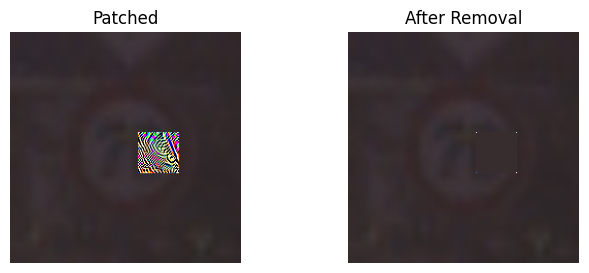

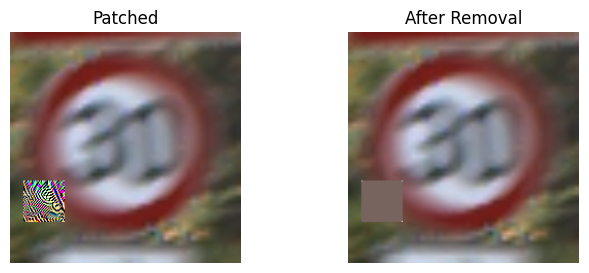

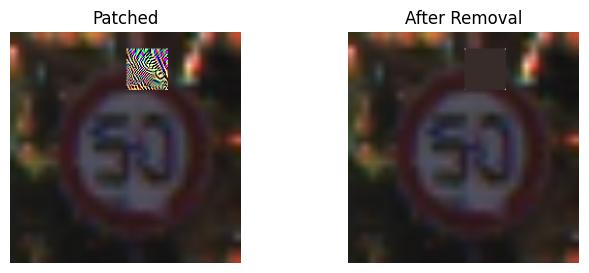

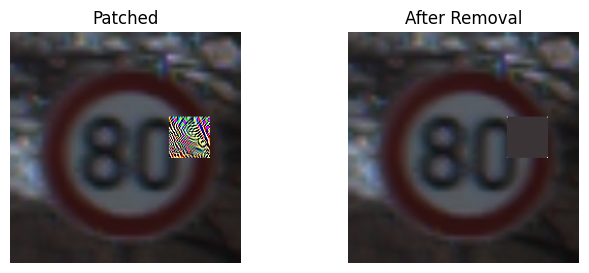

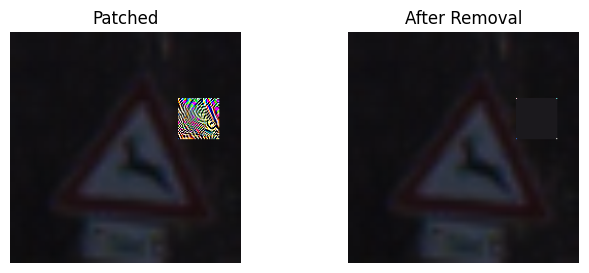

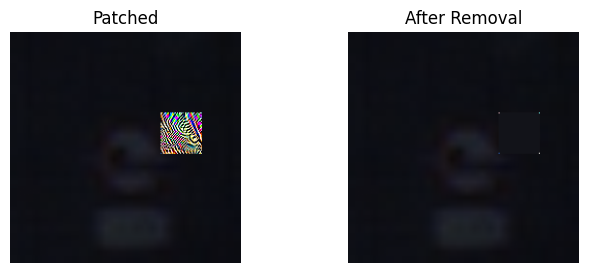

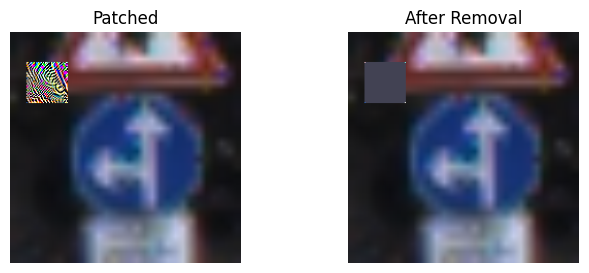

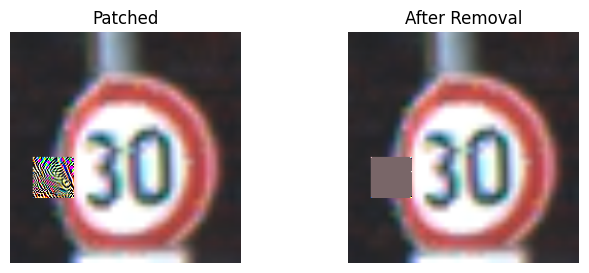

In [31]:
with torch.no_grad():
    images, _ = next(iter(seg_test_loader))
    images = images.to(DEVICE)

    #patched = apply_patch(images, patch)
    pred_mask = seg_model(images)
    cleaned = remove_patch(images, pred_mask)

for i in range(8):
    p_img = denormalize(images[i].cpu(), imagenet_mean, imagenet_std)
    c_img = denormalize(cleaned[i].cpu(), imagenet_mean, imagenet_std)

    p_img = p_img.permute(1,2,0).clamp(0,1)
    c_img = c_img.permute(1,2,0).clamp(0,1)

    plt.figure(figsize=(8,3))

    plt.subplot(1,2,1)
    plt.imshow(p_img)
    plt.title("Patched")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(c_img)
    plt.title("After Removal")
    plt.axis("off")

    plt.show()


## Measure Accuracy

In [32]:

def apply_patch(images, patch=patch, PATCH_SIZE=40):
    B, C, H, W = images.shape
    patched = images.clone()

    for i in range(B):
        x = random.randint(0, W - PATCH_SIZE)
        y = random.randint(0, H - PATCH_SIZE)
        patched[i, :, y:y+PATCH_SIZE, x:x+PATCH_SIZE] = patch

    return patched.clamp(-2.5, 2.5)

def build_defended_dataset(
    base_loader,
    apply_patch,
    seg_model,
    device
):
    seg_model.eval()

    defended_images = []
    defended_labels = []

    with torch.no_grad():
        for images, labels in base_loader:
            images = images.to(device)
            labels = labels.to(device)

            # apply attack once
            patched = apply_patch(images)

            # detect patch
            masks = seg_model(patched)

            # remove patch
            defended = remove_patch(patched, masks)

            defended_images.append(defended.cpu())
            defended_labels.append(labels.cpu())

    defended_images = torch.cat(defended_images)
    defended_labels = torch.cat(defended_labels)

    return TensorDataset(defended_images, defended_labels)


defended_dataset = build_defended_dataset(
    test_loader,
    apply_patch,
    seg_model,
    DEVICE
)

defended_loader = DataLoader(
    defended_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)
    


In [33]:
def evaluate_clean(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            preds = model(images).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total


defended_acc = evaluate_clean(model, defended_loader)
print(f"Defended Accuracy (fixed dataset): {defended_acc*100:.2f}%")


Defended Accuracy (fixed dataset): 97.75%
